In [1]:
#Read in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
#Read in data
%cd '/home/kishen/Documents/Projects/Customer Segmentation/data'

raw_data= pd.read_excel('Online Retail.xlsx', date_parser= 'InvoiceDate',)

/home/kishen/Documents/Projects/Customer Segmentation/data


**Preview and Inspect Data**

In [3]:
#Preview data
display(raw_data.shape)
raw_data.head()

(541909, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#View Stats and data types
display(raw_data.info())
raw_data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


None

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
#Check missing values
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Data Cleaning**

In [6]:
#Remove rows without a CustomerId
clean_df= raw_data.loc[~(raw_data.CustomerID.isna())]
                         
#Convert CustomerID to object                    
clean_df.loc[:, 'CustomerID']= clean_df['CustomerID'].astype('object')

/home/kishen/Documents/AcornAnalytics/SafeSport/safesport-notebook/venv/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Exploratory Data Analysis

What is the monthly revenue of the business?

In [7]:
#Create df and extract time series data for capturing metrics of interest
metrics= clean_df.copy()
metrics.loc[:, 'MonthYear']= metrics['InvoiceDate'].dt.to_period('M')

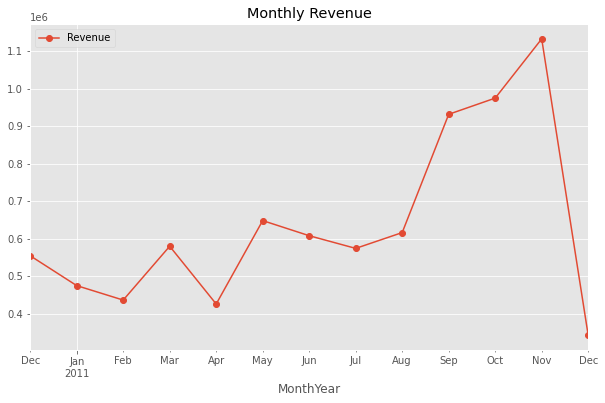

In [17]:
#Calculate monthly revenue
metrics.loc[:, 'Revenue']= metrics['Quantity'] * metrics['UnitPrice']
monthlyRevenue= metrics.groupby('MonthYear')['Revenue'].sum().reset_index()

#Plot Data
f, ax= plt.subplots(figsize= (10,6))
monthlyRevenue.plot(x='MonthYear', y='Revenue',
                    ax=ax, marker='o')
ax.set_title('Monthly Revenue');

What is the monthly revenue growth rate of the business?

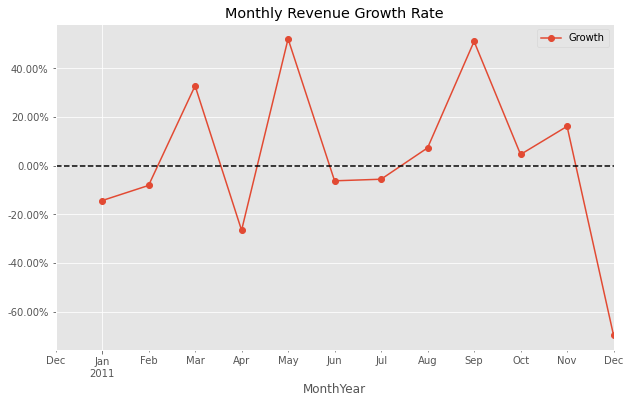

In [9]:
#Calculate % change between revenue for each month
monthlyRevenue.loc[:, 'monthlyGrowthRate']= monthlyRevenue['Revenue'].pct_change()

#Plot Data
f, ax= plt.subplots(figsize= (10,6))
monthlyRevenue.plot(x='MonthYear', y= 'monthlyGrowthRate', 
                    ax=ax, marker='o', label= 'Growth')

#PLot 0 as reference
ax.axhline(y=0, color = 'black', linestyle= '--')

#Set aesthetics
ax.set_title('Monthly Revenue Growth Rate')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.2%}'.format(x) for x in vals]);


How many active customers do we have per month? How about the number of monthly orders?

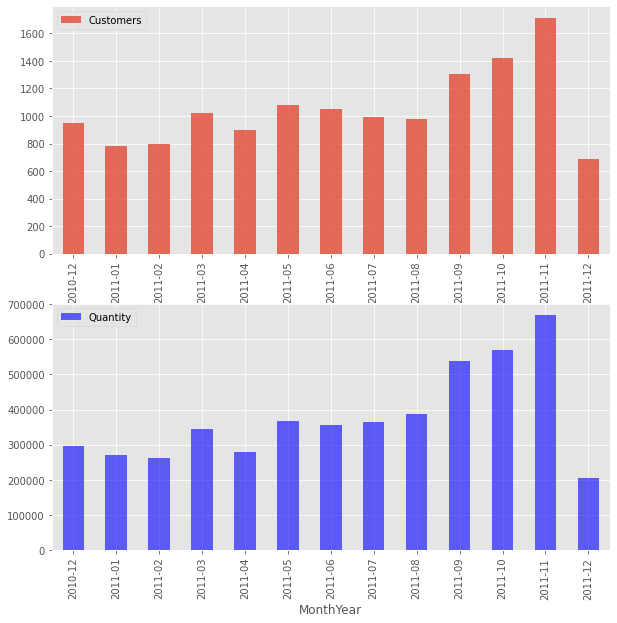

In [33]:
#Prep data
activeCustomers= metrics.groupby(['MonthYear'])['CustomerID'].nunique().reset_index()
monthlyOrders= metrics.groupby('MonthYear')['Quantity'].sum().reset_index()

f, ax= plt.subplots(2,1,figsize = (10,10))

activeCustomers.plot(x='MonthYear', y= 'CustomerID', 
               alpha=.8, kind='bar', 
               label= 'Customers', ax= ax[0])

monthlyOrders.plot(x='MonthYear', y= 'Quantity', 
                   color='blue', alpha=.6, kind='bar', ax=ax[1])

What is the new customer ratio?

A customer will be defined as new when it is their first time making a purchase. All subsequent transactions from the users will be identified as existing

In [ ]:
#Get date for when each customer would be a new customer
